<a href="https://colab.research.google.com/github/jakubtwalczak/Muller_Guido_Introduction_to_ML/blob/main/Rozdzia%C5%82_5_Ocena_i_doskonalenie_modelu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wstęp.

Do tej pory, aby ocenić nadzorowane modele, wykonywaliśmy następującą sekwencję operacji:
1. Dzieliliśmy zbiór danych na zbiór uczący i testowy przy pomocy funkcji train_test_split,
2. Budowaliśmy model na zbiorze uczącym, przy pomocy metody fit,
3. Ocenialiśmy predykcje modelu przy pomocy metody score na zestawie testowym.

Przykładowo:

In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = make_blobs(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression().fit(X_train, y_train)
print(f"Test score: {logreg.score(X_test, y_test)}")

Test score: 0.88


Celem dzielenia danych przy pomocy train_test_split jest potrzeba zmierzenia, jak dobrze model uogólnia na nieznanych wcześniej danych. Nie interesuje nas raczej wydajność uczenia, a to, jak model zachowuje się w stosunku do danych, których wcześniej nie poznał.

# Walidacja krzyżowa.

Jest to metoda statystyczna, pozwalająca oceniać wydajność uogólniania, bardziej stabilna niż zwykły podział na zbiory uczący i testowy. Dane dzielone są wielokrotnie i trenowane przez wiele modeli. Najczęściej stosuje się k-krotną walidację krzyżową, gdzie k to liczba określona przez użytkownika (najczęściej 5 lub 10). Dane dzielone są na k równych części, na których po kolei trenowany jest model; za pierwszym razem trenowany jest przy użyciu pierwszego podzbioru jako testowego i pozostałych jako uczących. Dokładność oceniana jest na pierwszym podzbiorze. Za drugim razem jest testowany na drugim podzbiorze i uczony na pozostałych itd., aż do wyczerpania wszystkich podzbiorów. Proces jest zilustrowany przez poniższy wykres.

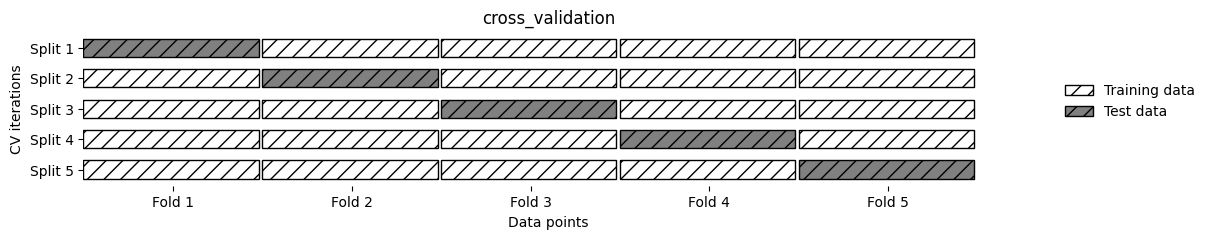

In [2]:
import mglearn

mglearn.plots.plot_cross_validation()

## Walidacja krzyżowa w scikit-learn.

Walidacja krzyżowa (lub kroswalidacja) jest zaimplementowana w funkcji cross_val_score. Parametrami są: model podlegający ocenie, dane treningowe i etykiety prawdy podstawowej.

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(max_iter=1000)

scores = cross_val_score(logreg, iris.data, iris.target)
print(f"Cross-validation scores: {scores}")

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


Domyślnie funkcja przeprowadza potrójną walidację krzyżową i zwraca pięć wartości dokładności. Można zmienić liczbę używanych podzbiorów - parametr cv.

In [4]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=10)
print(f"Cross-validation scores: {scores}")

Cross-validation scores: [1.         0.93333333 1.         1.         0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]


Powszechnym sposobem podsumowania dokładności walidacji krzyżowej jest obliczenie średniej. Na podstawie poniższego wyniku możemy stwierdzić, że dokładność modelu wynieść powinna ok. 0,97, jednak istnieje rozbieżność w dokładności między podzbiorami - od 0,93 do 1,00. Może to być zarówno konsekwencją niedużego zbioru danych, jak i ewentualnej zależności modelu od poszczególnych podzbiorów.

In [5]:
print(f"Mean cross-validation score: {scores.mean():.3f}")

Mean cross-validation score: 0.973


Zalety walidacji krzyżowej:
- każdy przykład danych znajduje się tylko w jednym podzbiorze, więc unikamy sytuacji, w której "trudne" dane znajdą się tylko w zbiorze treningowym; aby wynik walidacji krzyżowej był wysoki, model musi uogólniać dobrze wszystkie próbki,
- duża wartość informacyjna nt. tego, jak wrażliwy jest model na wybór danych uczących (tj. jakiej dokładności można się spodziewać w najgorszym i najlepszym scenariuszu),
- bardziej efektywne wykorzystanie danych; wydzielenie z całości danych zbioru testowego daje z reguły stosunkowo mniejszą liczbę danych treningowych niż każda iteracja kroswalidacji.

Główna wada - zwiększone koszty obliczeniowe.

Ważne - kroswalidacja nie zwraca modelu; podczas wywołania funkcji cross_val_score tworzy się wiele modeli, ale jej celem jest jedynie ocena uogólniania algorytmu na konkretnych zbiorze danych.

## Stratyfikowana k-krotna walidacja krzyżowa i in. strategie.

Dzielenie danych na k podzbiorów poprzez rozpoczęcie od pierwszej k-tej części danych nie zawsze jest dobrym pomysłem. Przykładem na to może być zbiór danych Iris.

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()
print(f"Iris labels:\n{iris.target}")

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


1/3 danych początkowych to klasa 0, następna 1/3 - klasa 1, ostatnia część - klasa 2. Kroswalidacja z trzema podzbiorami byłaby niemiarodajna; pierwszy podział zawierałby tylko próbki 0 w zbiorze testowym, a zbiór uczący składałby się wyłącznie z próbek 1 i 2 itd. Doprowadziłoby to do tego, że dokładność wyniosłaby 0, ponieważ model nie znałby próbek klasy 0 i nie byłby w stanie wobec nich generalizować.

Prosta strategia k-krotna zawodzi w tym wypadku. Dlatego na potrzeby klasyfikacji biblioteka Scikit-learn zapewnia możliwość skorzystania ze stratyfikowanej k-krotnej walidacji krzyżowej. Dzielimy dzięki niej dane tak, żeby proporcje między klasami były identyczne w całym zbiorze danych, jak i poszczególnych podzbiorach. Jeżeli 80% próbek w danych należy do klasy 0, a 20% do klasy 1, stratyfikowana k-krotna kroswalidacja zapewnia, że w każdym podziale danych 80% próbek przynależy do klasy 0, a 20% - do klasy 1.

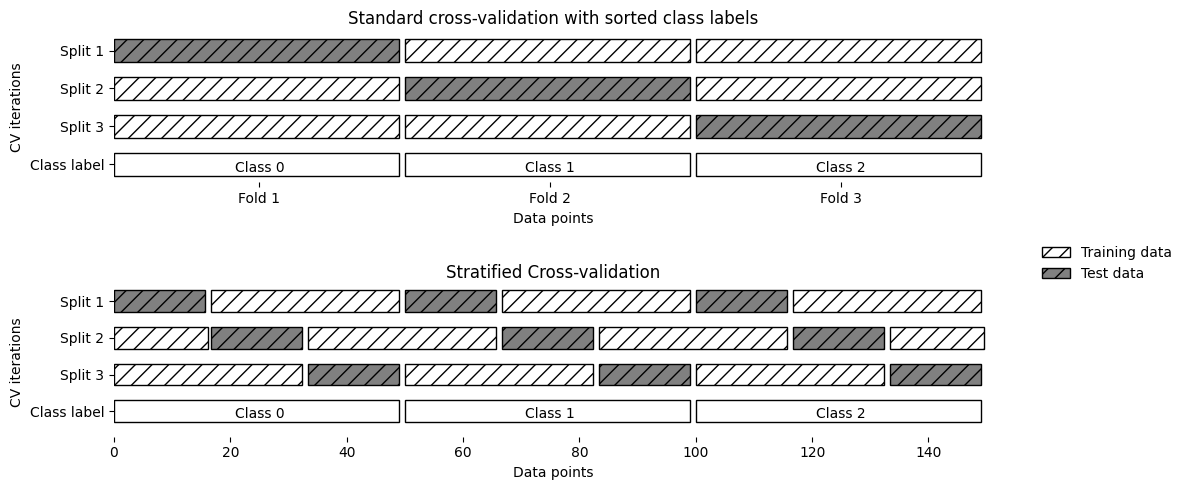

In [7]:
mglearn.plots.plot_stratified_cross_validation()

Użycie tej metody przy zadaniu klasyfikacji jest lepszym pomysłem niż zwykła kroswalidacja k-krotna. Daje ona bardziej wiarygodne oszacowanie wydajności uogólniania, szczególnie jeżeli jedna z klas jest mniej licznie reprezentowana w danych.

W przypadku regresji Scikit-learn domyślnie używa standardowej walidacji krzyżowej k-krotnej. Można oczywiście spróbować, aby każdy podzbiór był reprezentatywny dla różnych wartości celów regresji, ale jest to rzadko używana strategia.

Biblioteka Scikit-learn pozwala na lepszą kontrolę nad dzieleniem danych w ramach walidacji krzyżowej, przede wszystkim za pośrednictwem parametru cv. W większości przypadków skuteczne jest zastosowanie ww. metod (w odpowiednich zadaniach) z domyślnymi parametrami, ale są przypadki, w których można chcieć wykorzystać inną strategię.

Np. załóżmy sytuację, gdy chcemy odtworzyć wyniki kogoś innego i używamy w tym celu standardowej k-krotnej walidacji krzyżowej na zbiorze danych do klasyfikacji. Aby to zrobić, trzeba zaimportować rozdzielającą klasę KFold i utworzyć jej instancję z liczbą podzbiorów, których chcemy użyć.

In [8]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

Następnie możemy obiekt rozdzielacza przekazać jako parametr cv do funkcji cross_val_score.

In [9]:
print(f"Cross-validation scores:\n{cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")

Cross-validation scores:
[1.         1.         0.86666667 0.93333333 0.83333333]


Możemy w ten sposób zweryfikować podniesione wcześniej twierdzenie, że zastosowanie potrójnej niestratyfikowanej kroswalidacji w zbiorze Iris nie jest dobrym pomysłem.

In [10]:
kfold = KFold(n_splits=3)
print(f"Cross-validation scores:\n{cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")

Cross-validation scores:
[0. 0. 0.]


Innym sposobem rozwiązania tego problemu, zamiast stratyfikacji podzbiorów, jest tasowanie danych, aby ułożyć próbki w losowej kolejności wg etykiety. Ustawiamy parametr shuffle=True. Ponadto, by tasowanie było powtarzalne, ustawiamy parametr random_state, aby uzyskiwać za każdym razem ten sam wynik. Tasowanie danych przez ich podzieleniem daje znacznie lepszy wynik walidacji krzyżowej.

In [11]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print(f"Cross-validation scores:\n{cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")

Cross-validation scores:
[0.98 0.96 0.96]


Inną metodą jest walidacja krzyżowa z pominięciem (leave one out). Jest to k-krotna walidacja krzyżowa, w której każda krotność jest pojedynczą próbką - dla każdego podziału zbiór testowy jest jednoelementowy i składa się z jednej próbki danych. Może to się okazać bardzo czasochłonne w przypadku dużych zbiorów danych, ale czasem zapewnia lepsze oszacowania dla mniejszych zbiorów.

In [12]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print(f"Number of cv iterations: {len(scores)}")
print(f"Mean accuracy: {scores.mean():.2f}")

Number of cv iterations: 150
Mean accuracy: 0.97


Inną, bardzo elastyczną strategią jest walidacja krzyżowa z podziałem losowym (shuffle-split). Każdy podział sporządzony przy pomocy tej metody przydziela określoną część zbioru danych do zbioru uczącego i określoną część do zbioru testowego, a podział ten jest sporządzany n razy.

Poniżej wizualiacja procesu czterech iteracji dzielenia zbioru danych składającego się z dziesięciu punktów, ze zbiorem uczącym złożonym z 5 punktów i zbiorami testowymi po 2 punkty każdy.

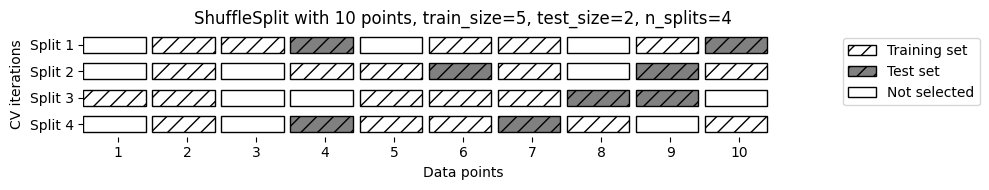

In [13]:
mglearn.plots.plot_shuffle_split()

Podzielmy więc zbiór danych na pół w dziesięciu iteracjach.

In [14]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print(f"Cross-validation scores:\n{scores}")

Cross-validation scores:
[0.94666667 0.98666667 0.96       0.97333333 0.97333333 0.94666667
 0.96       0.98666667 0.97333333 0.97333333]


Walidacja krzyżowa z losowym podziałem pozwala na kontrolę liczby iteracji niezależnie od rozmiaru zbioru treningowego i testowego, a także użycie w każdej iteracji tylko części danych, jeżeli suma ustawionych wartości parametrów train_size i test_size jest mniejsza niż 1. Może mieć to dużą przydatność, gdy pracujemy z dużym zbiorem danych.

Istnieje również stratyfikowany wariant - StratifiedShuffleSplit, który dostarczyć może bardziej wiarygodnych wyników dla zadań klasyfikacyjnych.

Innym powszechnie stosowanym rozwiązaniem jest walidacja krzyżowa z grupami. W danych mogą znajdować się silnie powiązane ze sobą grupy. Np. chcemy zbudować system rozpoznawania emocji na podstawie zdjęć twarzy; posiadamy zbiór danych obejmujący 100 zdjęć, na których każda osoba jest uchwycona wielokrotnie, a jej twarz prezentuje różne emocje. Przy domyślnej warstwowej walidacji krzyżowej możliwe jest, że zdjęcia tej samej osoby znajdą się w zbiorze treningowym i testowym, a więc modelowi nie będzie zapewniona odpowiednia różnorodność danych twarzy, a tym samym nie nauczy się dobrze uogólniać. Aby dokładnie ocenić uogólnianie z użycie nowych twarzy, musimy się upewnić, że dane uczące i testowe zawierają zdjęcia różnych osób.

Możemy w tym celu użyć klasy GroupKFold, która jako argument przyjmuje tablicę groups. Tablica ta wskazuje grupy w danych, które nie powinny być dzielone podczas tworzenia zestawów uczących i testowych ani mylone z etykietą klasy. Takie zastosowanie jest powszechne w zastosowaniach medycznych (np. możemy mieć dużo próbek od tego samego pacjenta, ale chcemy uogólniać na innych pacjentów), czy też w rozpoznawaniu mowy.

Użyjmy syntetycznego zbioru danych z grupowaniem podanym przez tablicę groups. Zbiór składa się z 12 punktów danych, a dla każdego z nich groups określa, do której grupy należy punkt. W poniższym przykładzie tablica groups podaje, że istnieją cztery grupy.

In [15]:
from sklearn.model_selection import GroupKFold
X, y = make_blobs(n_samples=12, random_state=0)
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups=groups, cv=GroupKFold(n_splits=3))
print(f"Cross-validation scores:\n{scores}")

Cross-validation scores:
[0.75       0.6        0.66666667]


Poniższy wykres prezentuje, jak podziały są obliczane wg etykiet. Dla każdego podziału grupa należy w całości albo dla zbioru treningowego, albo testowego (nie zawsze są one posortowane, jak na poniższej ilustracji).

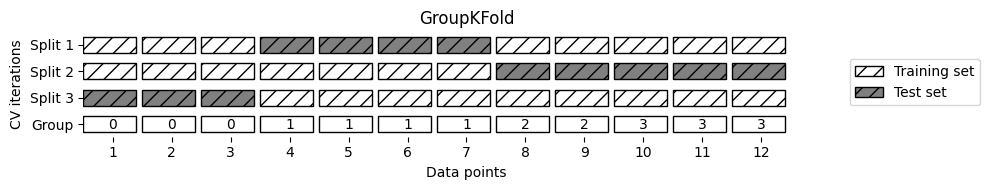

In [16]:
mglearn.plots.plot_group_kfold()

Scikit-learn zawiera jeszcze więcej strategii podziału dla walidacji krzyżowej. Powyżej zostały jednak omówione najbardziej popularne z nich.

# Przeszukiwanie siatki.

Znalezienie wartości ważnych parametrów modelu jest trudnym, ale zawsze niezbędnym zadaniem. Scikit-learn zawiera metody, które są w tym pomocne. Najczęściej stosowaną jest przeszukiwanie siatki - wypróbowanie wszystkich możliwych kombinacji wskazanych parametrów i zaimplementowanie najbardziej wydajnej. Załóżmy, że dla modelu SVM próbujemy po sześć różnych wartości gamma i C. Daje to siatkę 6 x 6, a więc 36 możliwych kombinacji parametrów.

Możemy samodzielnie zaimplementować proste przeszukiwanie siatki - wystarczy pętla z dwoma parametrami, uczeniem i oceną algorytmu dla każdej kombinacji.

In [17]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print(f"Size of training set: {X_train.shape[0]}")
print(f"Size of test set: {X_test.shape[0]}")
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print(f"Best score: {best_score}")
print(f"Best parameters: {best_parameters}")

Size of training set: 112
Size of test set: 38
Best score: 0.9736842105263158
Best parameters: {'C': 100, 'gamma': 0.001}


Możemy na podstawie ww. wyniku pokusić się o założenie, że znaleźliśmy model o dokładności ponad 97%. Twierdzenie to może być jednak błędne - jedynie znaleźliśmy kombinację parametrów z największą dokładnością w zbiorze testowym, niekoniecznie jednak przenoszącą się na nowe dane. Ponieważ wykorzystaliśmy dane testowe do dostosowania parametrów, nie możemy używać ich do oceny modelu. Potrzebujemy więc niezależnego zbioru danych, który posłuży do oceny, a nie został użyty do stworzenia modelu.

Jednym ze sposobów na rozwiązanie tego problemu jest ponowne podzielenie danych. Dysponować będziemy teraz trzema zbiorami: treningowym do uczenia modelu, walidacyjnym do doboru parametrów modelu i testowym do oceny wydajności wybranych parametrów.

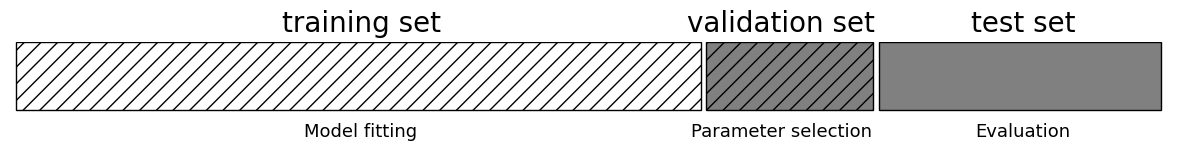

In [18]:
mglearn.plots.plot_threefold_split()

Po wybraniu najlepszych parametrów za pomocą zbioru walidacyjnego możemy przebudować model przy użyciu znalezionych ustawień parametrów. Model uczymy jednak zarówno na danych uczących, jak i walidacyjnych, więc w ten sposób do zbudowania modelu możemy użyć jak najwięcej danych.

In [19]:
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print(f"Size of training set: {X_train.shape[0]}")
print(f"Size of validation set: {X_valid.shape[0]}")
print(f"Size of test set: {X_test.shape[0]}")
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print(f"Best score on validation set: {best_score}")
print(f"Best parameters: {best_parameters}")
print(f"Test set score with best parameters: {test_score}")

Size of training set: 84
Size of validation set: 28
Size of test set: 38
Best score on validation set: 0.9642857142857143
Best parameters: {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.9210526315789473


Najlepszy wynik w zestawie walidacyjnym to 0,96 - nieznacznie niższy niż poprzednio, prawdopodobnie dlatego, że do uczenia użytych było mniej danych (z powodu potrzeby wydzielenia zbioru walidacyjnego). Wynik w zbiorze testowym jest jeszcze niższy - wynosi 0,92. Można więc stwierdzić, że nowe dane są klasyfikowane w 92% poprawnie, a nie 97%, jak wyglądało to przy pierwszym przeszukaniu siatki.

Rozróżnienie między zbiorem treningowym, walidacyjnym i testowym jest fundamentalne przy stosowaniu uczenia maszynowego w praktyce. Wszelkie wybory dokonane na podstawie informacji o dokładności modelu w zbiorze testowym "przepuszczają" informacje ze zbioru testowego do modelu. Dlatego tak ważne jest, żeby zbiór testowy zachować tylko do oceny modelu, a analizę eksploracyjną i dobór parametrów wykonywać przy użyciu kombinacji zbioru uczącego i walidacyjnego.